<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import boston_housing
from sklearn.preprocessing import Normalizer
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras as keras

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

norm_x = Normalizer().fit(X_train)
X_train = norm_x.transform(X_train)
X_test = norm_x.transform(X_test)

norm_x = Normalizer().fit(y_train)
y_train = norm_x.transform(y_train)
y_test = norm_x.transform(y_test)

model = Sequential()
model.add(Dense(16, input_dim=13, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=False)

model.summary()

score = model.evaluate(X_test, y_test)
print("Accuracy Score:", score[1]*100, "%")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________
102/102 [==============================] - 0

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [9]:
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model_mnist = Sequential()
print(X_train.shape)
# Input => Hidden
model_mnist.add(Dense(16, input_dim=784, activation="relu"))
model_mnist.add(Dense(16, activation="relu"))
model_mnist.add(Dense(16, activation="relu"))
model_mnist.add(Dense(16, activation="relu"))
model_mnist.add(Dense(10,activation="softmax"))

#Compile
model_mnist.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get("loss"))

history = LossHistory()
model_mnist.fit(X_train, y_train, epochs=10, verbose=False, callbacks=[history])


(60000, 784)
10000/10000 [==============================] - 0s 44us/sample - loss: 0.2602 - acc: 0.9279


Test Accuracy Score: 92.79000163078308 %


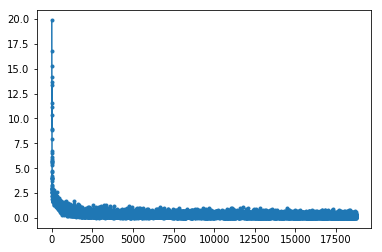

In [17]:
score_mnist = model_mnist.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy Score:", score_mnist[1]*100, "%")
plt.plot(range(1, len(history.losses) + 1), history.losses, marker=".");

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.